In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import numpy as np
import os

Text(0.5, 1.0, 'diag')

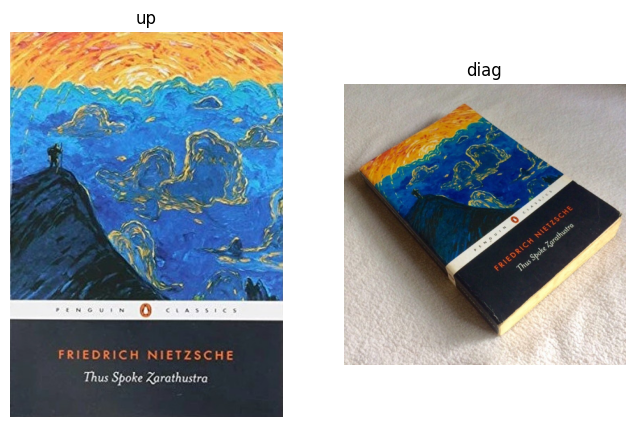

In [28]:
up_path = os.path.join(os.getcwd(), "..", "assets", "upfront_book.jpg")
diag_path = os.path.join(os.getcwd(), "..", "assets", "diagonal_book.jpg")

up_img = cv.imread(up_path)[:,:,::-1]
diag_img = cv.imread(diag_path)[:,:,::-1]

plt.figure(figsize=[8,5])
plt.subplot(121); plt.axis("off"); plt.imshow(up_img); plt.title("up") 
plt.subplot(122); plt.axis("off"); plt.imshow(diag_img); plt.title("diag") 

[120 232  48  58  25 201  87 236 151  55 161  25 230 209  10 148 137 185
 201   0  90  39  74  31 241 212   1 127  82  14 134  98]


Text(0.5, 1.0, 'diag keypoints')

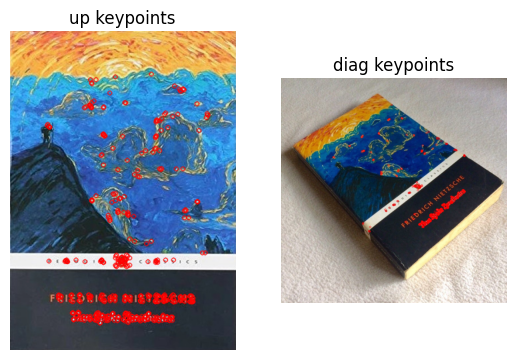

In [33]:
up_gray = cv.cvtColor(up_img, cv.COLOR_RGB2GRAY)
diag_gray = cv.cvtColor(diag_img, cv.COLOR_RGB2GRAY)

# ORB (Oriented FAST and Rotated BRIEF) is a feature detection and description algorithm
# that identifies keypoints in images and computes their corresponding descriptors.
#
# - Keypoints: These are specific points in the image that are considered interesting
#   or significant for matching and recognition. They represent distinctive features
#   such as corners or edges.
#
# - Descriptors: For each keypoint, a descriptor is computed that encodes the local
#   appearance of the region around the keypoint. This descriptor can be used for
#   matching keypoints between different images, allowing for image alignment and
#   object recognition.
MAX_NUM_FEATURES = 500
orb = cv.ORB_create(MAX_NUM_FEATURES)
keyPoints1, descriptors1 = orb.detectAndCompute(up_gray, None)
keyPoints2, descriptors2 = orb.detectAndCompute(diag_gray, None)
print(descriptors1[0])

display_1 = cv.drawKeypoints(
    up_img,
    keyPoints1,
    outImage=np.array([]),
    color=(255, 0, 0),
    flags=cv.DRAW_MATCHES_FLAGS_DEFAULT,
)
display_2 = cv.drawKeypoints(
    diag_img,
    keyPoints2,
    outImage=np.array([]),
    color=(255, 0, 0),
    flags=cv.DRAW_MATCHES_FLAGS_DEFAULT,
)

plt.figure()
plt.subplot(121); plt.axis("off"); plt.imshow(display_1); plt.title("up keypoints")
plt.subplot(122); plt.axis("off"); plt.imshow(display_2); plt.title("diag keypoints")

Text(0.5, 1.0, 'Result Matching')

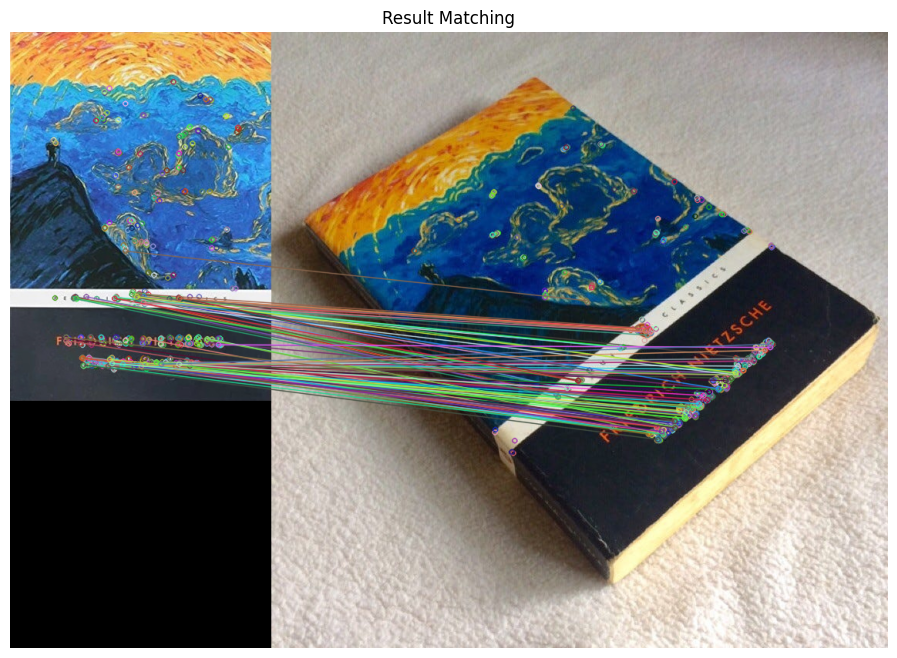

In [30]:
# BRUTEFORCE_HAMMING is a brute-force descriptor matcher that compares descriptors using the Hamming distance.
# Typically used with binary descriptors (e.g., ORB, BRIEF, BRISK). It finds the closest matches by computing
# the Hamming distance (number of differing bits) between each descriptor in two sets.
matcher = cv.DescriptorMatcher_create(cv.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches_partial = matcher.match(
    queryDescriptors=descriptors1, trainDescriptors=descriptors2, mask=None
)
# sorting matcher by score
matches_partial = sorted(matches_partial, key=lambda x: x.distance, reverse=False)

# Picking the 20% best matches (after sorting)
numGoodMatches = int(len(matches_partial) * 0.2)
matches = matches_partial[:numGoodMatches]

result_display = cv.drawMatches(
    up_img, keyPoints1, diag_img, keyPoints2, matches1to2=matches, outImg=None
)

plt.figure(figsize=[30, 8])
plt.imshow(result_display)
plt.axis("off")
plt.title("Result Matching")

In [31]:
# 2 -> a point is made of two coordinates (x, y)
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

"""
>> matches[0].queryIdx -> index of the corresponding keypoint for the match in KeyPoints1
>> matches[0].trainIdx -> index of the corresponding keypoint for the match in KeyPoints2
"""
print(matches[0])
print(f"{keyPoints1[0]}, {keyPoints2[0]}")
print(f"{matches[0].queryIdx}, {matches[0].trainIdx}")
print(f"{keyPoints1[matches[0].queryIdx].pt}")
print(f"{keyPoints2[matches[0].trainIdx].pt}")

for i, _match in enumerate(matches):
    # [i, :] -> put (x, y) at position i
    points1[i, :] = keyPoints1[_match.queryIdx].pt
    points2[i, :] = keyPoints2[_match.trainIdx].pt

# cv.RANSAC is good for filtering outliers (bad matches)
# beware of the points order
homography, mask = cv.findHomography(points2, points1, method=cv.RANSAC)

< cv2.DMatch 000001D20445E9B0>
< cv2.KeyPoint 000001D203B3BFC0>, < cv2.KeyPoint 000001D203B3BD20>
382, 496
(136.8576202392578, 344.2176513671875)
(369.0677185058594, 469.3968200683594)


Text(0.5, 1.0, 'registered')

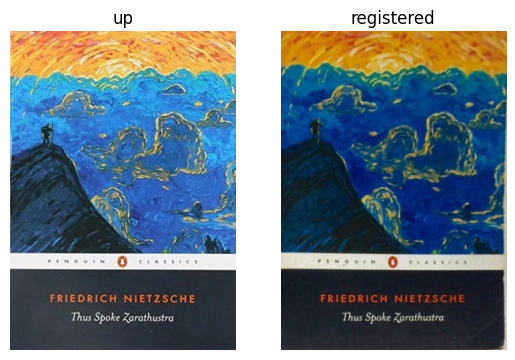

In [32]:
height, width, channels = up_img.shape
# also called aligned or warped image
registered_img = cv.warpPerspective(diag_img, homography, (width, height))

plt.figure()
plt.subplot(121); plt.imshow(up_img); plt.axis("off"); plt.title("up")
plt.subplot(122); plt.imshow(registered_img); plt.axis("off"); plt.title("registered")